# Business Understanding

Task 1:
Through EDA find at least 3 useful insights in the dataset, that could be used as recommendations for house sellers and/or buyers

Task 2:
Model the dataset with a multivariate linear regression to predict the sale price of houses as accurately as possible (R-squared: 0.7 to 0.9)

# Data Mining

In [1329]:
reset -fs

In [1330]:
# Importing the most important packages and setting the style for following plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import statistics
from statsmodels.stats.outliers_influence import variance_inflation_factor

plt.style.use('seaborn')

In [1331]:
# Importing the dataset and first glance
df = pd.read_csv("/Users/tjadeappel/nf-sep-20/2020-ds-Project-EDA/King_County_House_prices_dataset.csv", na_values="?")
print(df.shape)
df.head()

(21597, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# Data Cleaning

Key Questions:  
1. What types of data does the dataset contain?
2. Do any values have to converted in their type?
3. Are their missing values? If yes, how many and how should they be handled?
4. Are their outliers? If yes, how should they be handled?

In [1332]:
# What types of data does the dataset contain
df.info()
print(type(df.date[3]))
# Date is saved as a string

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21143 non-null float64
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(9), int64(11), object(1)
memory usage: 3.5+ MB
<class 'str

In [1333]:
# Check for missing values
missing = pd.DataFrame(df.isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/df.shape[0]*100,1)
missing[missing.Number!=0]

,Number,Percentage
waterfront,2376,11.0
view,63,0.3
sqft_basement,454,2.1
yr_renovated,3842,17.8


0.0    19075
1.0      146
Name: waterfront, dtype: int64


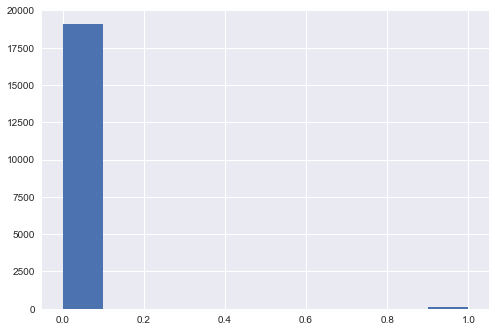

In [1334]:
# What is the distribution of houses with a waterfront?
print(df.waterfront.value_counts())
df.waterfront.hist();

In [1335]:
# Only very few houses have waterfronts --> assumption: houses with no value in column don't have a waterfront
# Therefore those are replaced with 0.
df.waterfront.fillna(value = 0, inplace = True)

0.0


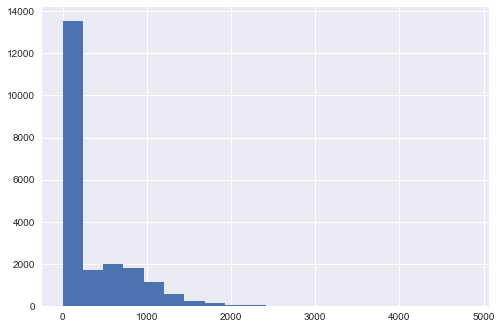

In [1336]:
# What is the distribution of sqft_basement values?
df.sqft_basement.hist(bins = 20)
print(df.sqft_basement.median())

In [1337]:
# Most houses dont seem to have a basement. Therefore the assumption is that missing values can be filled with the median 0.
df.sqft_basement.fillna(value = 0, inplace = True)

# Dropping rows with missing columns for view due to very small percentage of missing values
df.dropna(subset = ["view"], inplace=True)

# The column id will  probably not have much information, which is why it will be dropped
df.drop("id", axis = 1, inplace = True)

In [1338]:
# Coordinates lat and long will be dropped and zipcode will be the reference for location (categorical --> dummies)
#df.drop(["lat","long"], axis = 1, inplace = True)

# Yr_built and yr_renovated can probably merged into a new feature (age_lastchange) and the respective columns dropped
df["yr_lastchange"] = df[["yr_built", "yr_renovated"]].max(axis=1)
df['sales_yr']=df['date'].astype(str).str[-4:]
df['age_lastchange']=df['sales_yr'].astype(int)-df['yr_lastchange']
df.drop(['yr_lastchange',"yr_built", "yr_renovated","sales_yr","date"], axis = 1, inplace = True)

# Data Exploration

1. Which features are continuous variables and which categorical?
2. Check for correlations between features and label
3. Check for correlation between features
4. What recommendations can be made to potential house sellers/buyers

## 3 Recommendations

### Best price / sq ft

In [1339]:
# Adding column for the searched feature
df["price_per_sqft_living"] = df["price"]/df["sqft_living"]

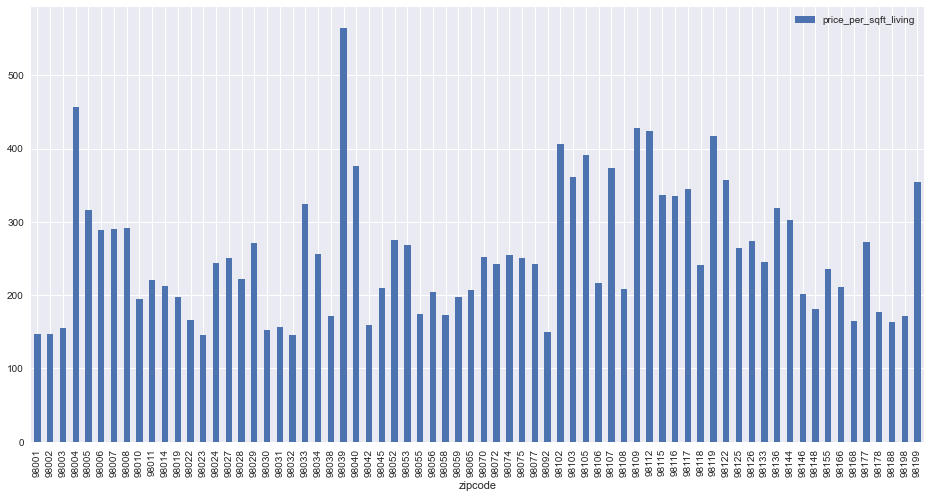

In [1340]:
# Plotting a barchart for the median price / sq ft by zipcode 
median_price_per_sqft_living_by_zipcode = df.groupby("zipcode").median()["price_per_sqft_living"].reset_index()
median_price_per_sqft_living_by_zipcode.plot(kind = "bar", x = "zipcode", y = "price_per_sqft_living", figsize = (16,8));

In [1341]:
# Grabbing the 3 cheapest zipcodes
median_price_per_sqft_living_by_zipcode.sort_values(["price_per_sqft_living"], ascending = True, inplace = True)
median_price_per_sqft_living_by_zipcode.head(3)

,zipcode,price_per_sqft_living
13,98023,144.886364
20,98032,146.202094
0,98001,146.759259


In [1342]:
# Removing the column again (not useful in regression later)
df.drop("price_per_sqft_living", axis = 1, inplace = True)

### Value of King County grade

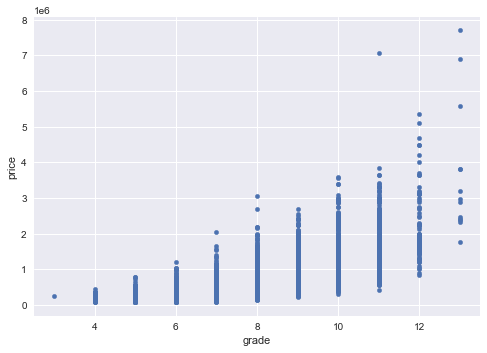

In [1343]:
# Plotting all data points
df.plot(x = "grade", y = "price", kind = "scatter");

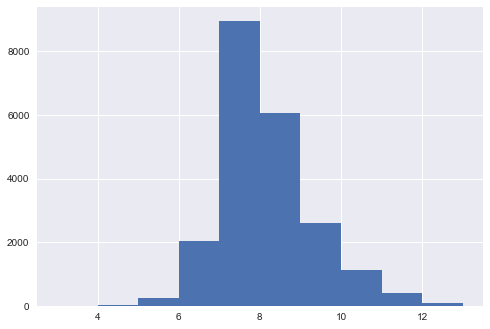

In [1344]:
# Distribution of given grades
df.grade.hist();

In [1234]:
# Checking the median price in King County and the median price grouped by grade categories
print(df.price.median())
df.groupby("grade").median()["price"]


450000.0


grade
3      262000.0
4      200000.0
5      228700.0
6      275500.0
7      375000.0
8      510000.0
9      721750.0
10     913077.0
11    1280000.0
12    1820000.0
13    2980000.0
Name: price, dtype: float64

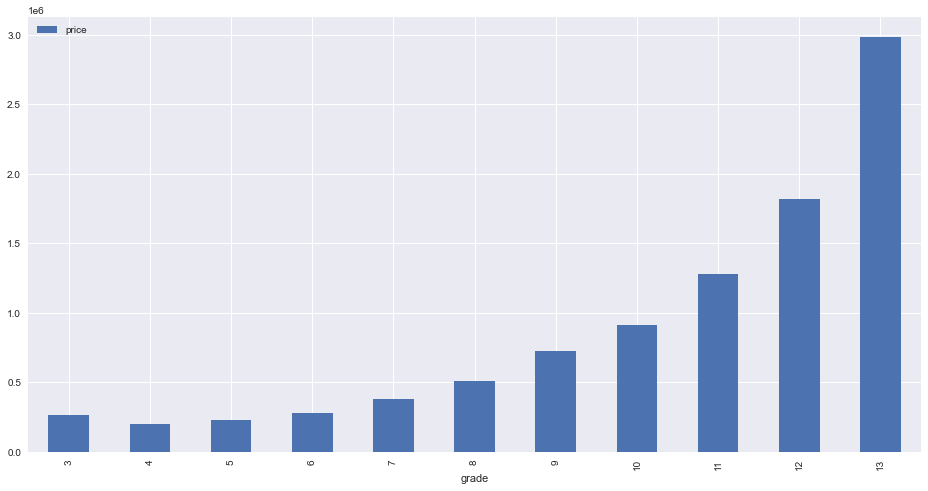

In [1235]:
# Visualizing median price by grade as barplot
median_price_by_grade = df.groupby("grade").median()["price"].reset_index()
median_price_by_grade.plot(kind = "bar", x = "grade", y = "price", figsize = (16,8));

In [1236]:
# Checking the grade feature for correlation with other indicators of a quality house
df.corr()["grade"]

price             0.668307
bedrooms          0.356095
bathrooms         0.665312
sqft_living       0.762398
sqft_lot          0.115122
floors            0.458694
waterfront        0.081195
view              0.249727
condition        -0.147326
grade             1.000000
sqft_above        0.755977
sqft_basement     0.164272
zipcode          -0.185710
lat               0.113787
long              0.200821
sqft_living15     0.713462
sqft_lot15        0.121435
age_lastchange   -0.459879
Name: grade, dtype: float64

### Rich golf player wants to live close to downtown Seattle

In [1355]:
# Zipcodes for 5 best golf clubs are taken from google maps and some metrics compared
zipcodes_golf_clubs = [98126, 98108, 98039, 98112, 98119]
df["price_per_sqft_living"] = df["price"]/df["sqft_living"]
df_zipcodes_golf_clubs = df.copy()
df_zipcodes_golf_clubs = df_zipcodes_golf_clubs.loc[df_zipcodes_golf_clubs['zipcode'].isin(zipcodes_golf_clubs)]

df_zipcodes_golf_clubs.groupby("zipcode").median().reset_index()[["zipcode","price_per_sqft_living", "age_lastchange", "sqft_basement","floors"]]

,zipcode,price_per_sqft_living,age_lastchange,sqft_basement,floors
0,98039,565.165614,28.5,0.0,2.0
1,98108,208.301144,61.5,305.0,1.0
2,98112,424.581276,83.5,442.5,2.0
3,98119,416.652778,76.0,285.0,2.0
4,98126,274.390244,69.0,0.0,1.0


In [ ]:
# Removing the column again (not useful in regression later)
df.drop("price_per_sqft_living", axis = 1, inplace = True)

## Splitting continuous and categorical variables

In [1276]:
# Converting categorical variables to Strings
df[["zipcode","bedrooms","bathrooms","floors","view","condition","grade"]] = df[["zipcode","bedrooms","bathrooms","floors","view","condition","grade"]].astype(str)

# Dividing into continuous and categorical variables.
continuous_var = list(df.select_dtypes(
                        ['int64','float64','bool']).columns.values)
categorical_var=list(df.select_dtypes(
                        ['object']).columns.values)
categorical_var

['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade', 'zipcode']

## Checking for correlation using plots and correlation matrix

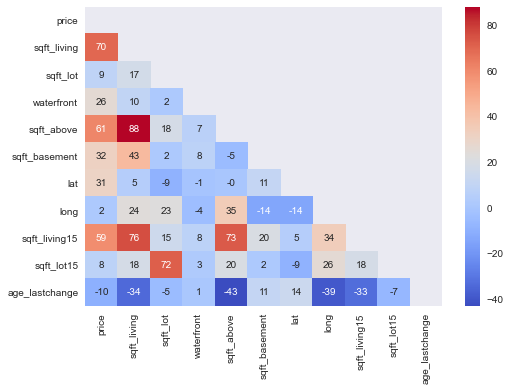

In [1277]:
# Creating Heatmap for correlation coefficients of all continuous variables
X_dum=pd.get_dummies(df[continuous_var].copy())
mask = np.triu(X_dum.corr())
ax = sns.heatmap(round(X_dum.corr()*100,0)
                 ,annot=True
                 ,mask=mask
                 ,cmap='coolwarm')

In [1278]:
# Checking R-squared for single continuous variables
print('R squared for each possible continuous explanatory variable:' )
for explanatory_var in continuous_var:
    model = 'price ~ {:}'.format(explanatory_var)
    rs = smf.ols(formula=model, data=df).fit().rsquared
    print('{:7s} \t \t= {:.3}'.format(explanatory_var, rs))

R squared for each possible continuous explanatory variable:
price   	 	= 1.0
sqft_living 	 	= 0.492
sqft_lot 	 	= 0.00816
waterfront 	 	= 0.0672
sqft_above 	 	= 0.367
sqft_basement 	 	= 0.102
lat     	 	= 0.0948
long    	 	= 0.000503
sqft_living15 	 	= 0.343
sqft_lot15 	 	= 0.00692
age_lastchange 	 	= 0.00955


1. Sqft_living, sqft_above, sqft_living15, bathrooms and view might be interesting features to consider.
2. They seem to have a good positive linear correlation with the price and the highest single R-squared values.
3. But there seems to be a lot of correlation between those features.

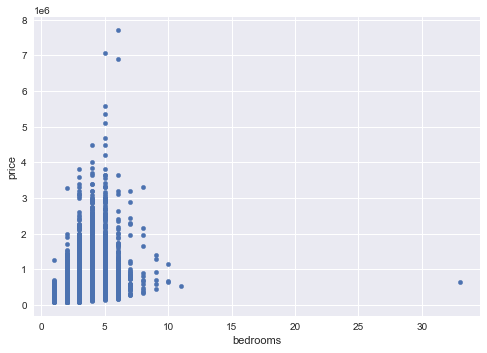

In [1245]:
# Visualizing the data
df.plot(x = "bedrooms", y = "price", kind = "scatter");
# Might me even more useful without the outlier


In [1280]:
#df.bedrooms.plot(kind='box',figsize=(8,8));
#df.bedrooms.describe().round(2)

# Removing outlier with 33 bedrooms
df.drop(df[df['bedrooms'] == "33"].index , inplace=True)

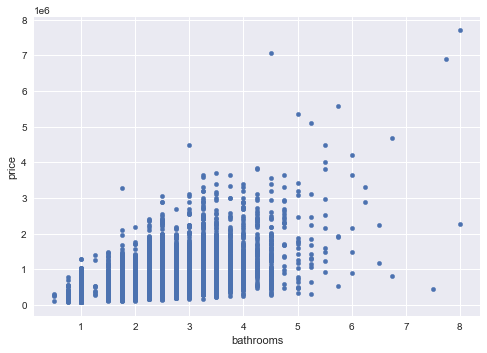

In [1247]:
df.plot(x = "bathrooms", y = "price", kind = "scatter");

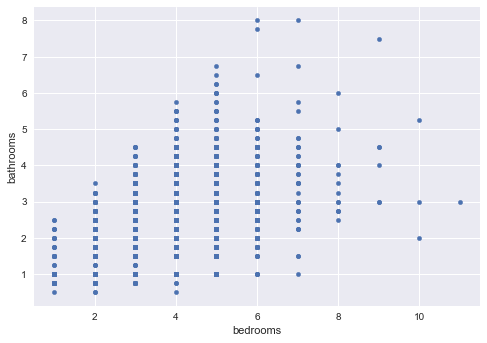

In [1248]:
df.plot(x = "bedrooms", y = "bathrooms", kind = "scatter");

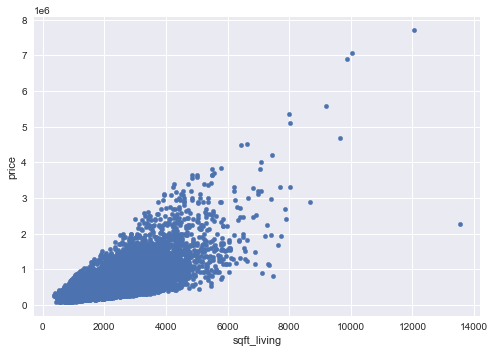

In [1249]:
df.plot(x = "sqft_living", y = "price", kind = "scatter");

# Might be even more useful without the outlier

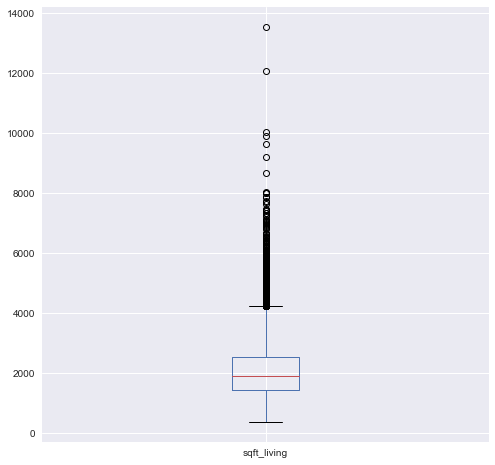

In [1281]:
df.sqft_living.plot(kind='box',figsize=(8,8));
df.sqft_living.describe().round(2)

# Removing outlier
df.drop(df[df['sqft_living'] == 13540.00].index , inplace=True)

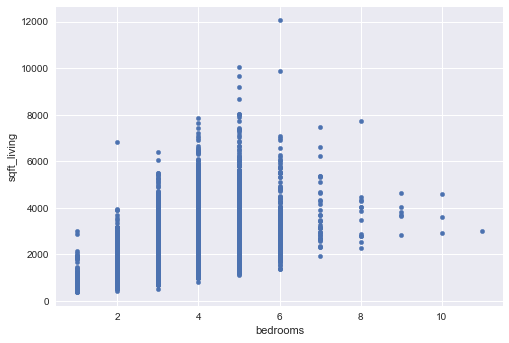

In [1251]:
df.plot(x = "bedrooms", y = "sqft_living", kind = "scatter");

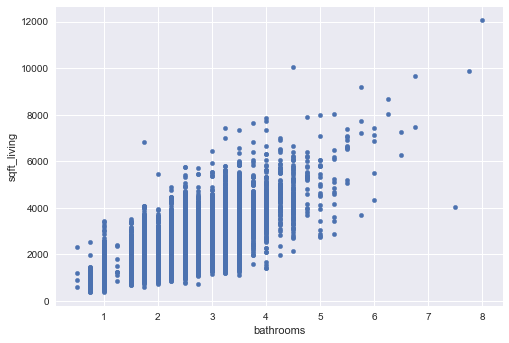

In [1252]:
df.plot(x = "bathrooms", y = "sqft_living", kind = "scatter");

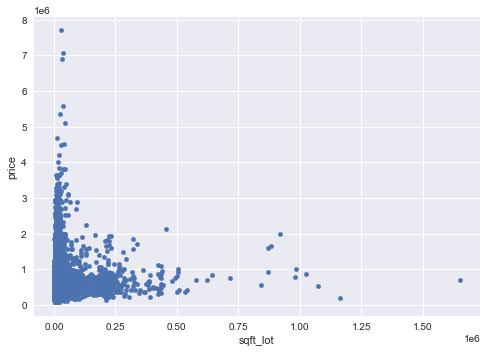

In [1253]:
df.plot(x = "sqft_lot", y = "price", kind = "scatter");

# Not very useful

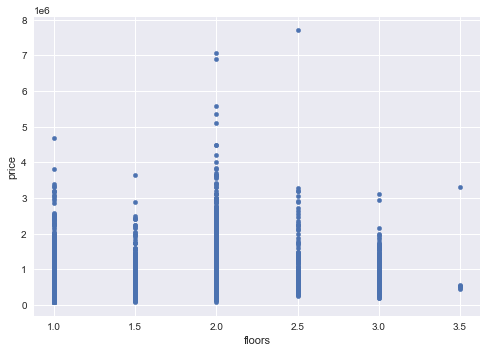

In [1254]:
df.plot(x = "floors", y = "price", kind = "scatter");

# Maybe somewhat of a quadratic correlation

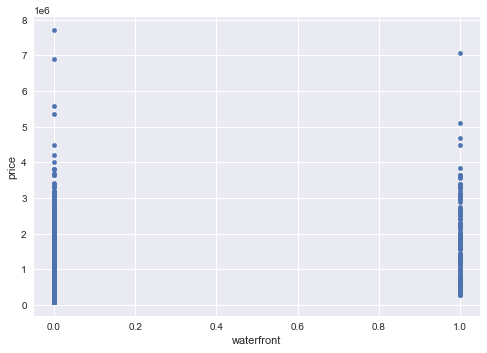

In [1255]:
df.plot(x = "waterfront", y = "price", kind = "scatter");

# Not insightful, but useful categorical variable

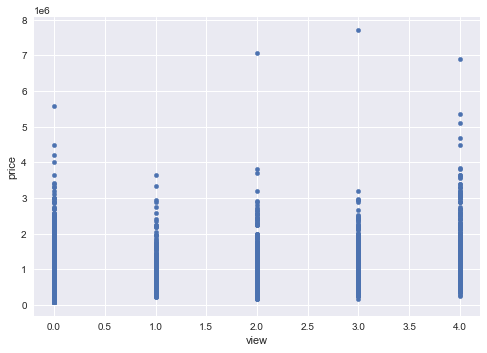

In [1256]:
df.plot(x = "view", y = "price", kind = "scatter");




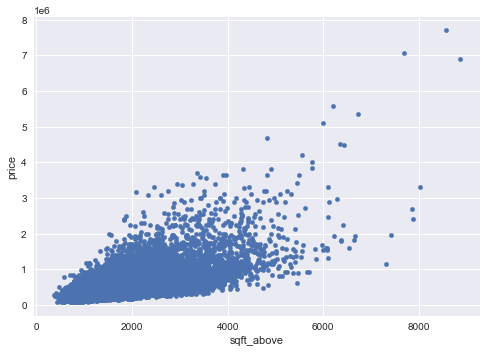

In [1257]:
df.plot(x = "sqft_above", y = "price", kind = "scatter");

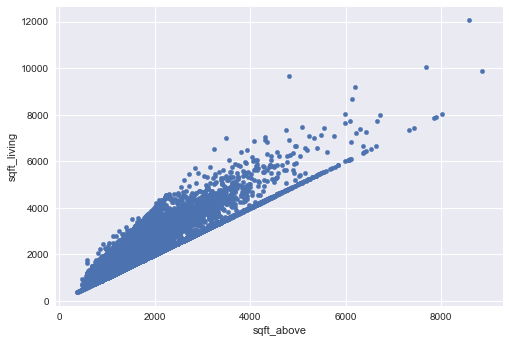

In [1258]:
df.plot(x = "sqft_above", y = "sqft_living", kind = "scatter");

# Column can be dropped

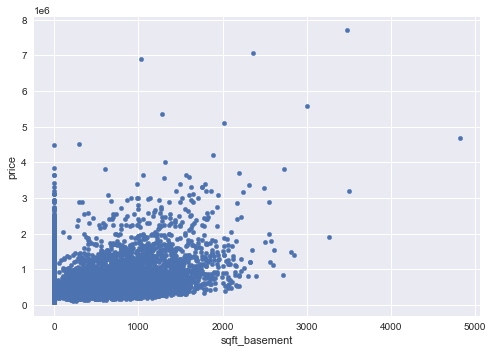

In [1259]:
df.plot(x = "sqft_basement", y = "price", kind = "scatter");

# Maybe more useful, when NaN are not replaced with 0

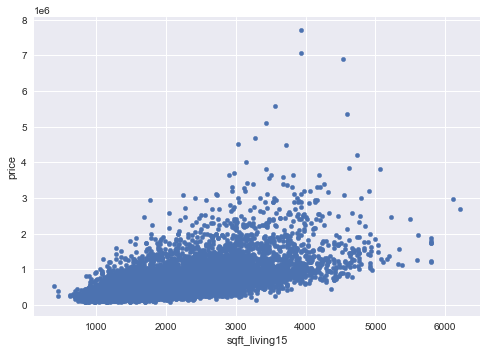

In [1260]:
df.plot(x = "sqft_living15", y = "price", kind = "scatter");

# Seems useful but Multicolinearity with sqft_living and grade

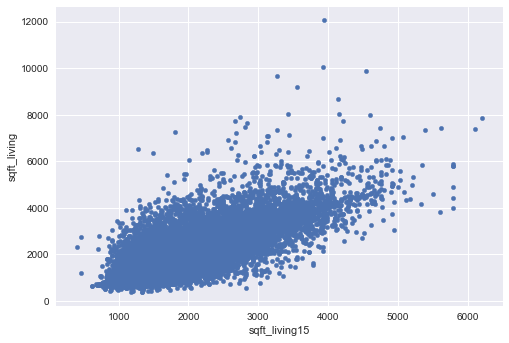

In [1261]:
df.plot(x = "sqft_living15", y = "sqft_living", kind = "scatter");

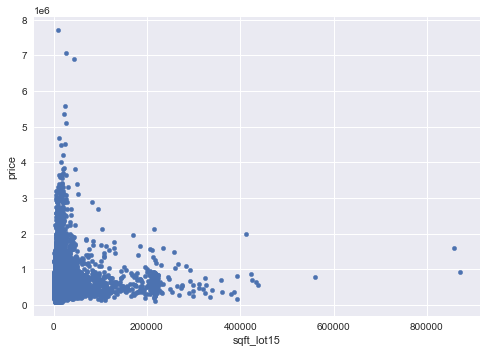

In [1262]:
df.plot(x = "sqft_lot15", y = "price", kind = "scatter");

# Not useful

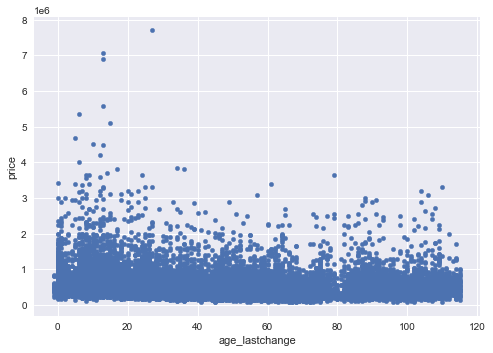

In [1263]:
df.plot(x = "age_lastchange", y = "price", kind = "scatter");

In [1217]:
# Checking R-squared for single continuous variables again
print('R squared for each possible continuous explanatory variable:' )
for explanatory_var in continuous_var:
    model = 'price ~ {:}'.format(explanatory_var)
    rs = smf.ols(formula=model, data=df).fit().rsquared
    print('{:7s} \t \t= {:.3}'.format(explanatory_var, rs))

R squared for each possible continuous explanatory variable:
price   	 	= 1.0
bedrooms 	 	= 0.099
bathrooms 	 	= 0.275
sqft_living 	 	= 0.492
sqft_lot 	 	= 0.00791
floors  	 	= 0.0659
waterfront 	 	= 0.0673
view    	 	= 0.156
condition 	 	= 0.00126
grade   	 	= 0.446
sqft_above 	 	= 0.366
sqft_basement 	 	= 0.101
lat     	 	= 0.0948
long    	 	= 0.000488
sqft_living15 	 	= 0.342
sqft_lot15 	 	= 0.00667
age_lastchange 	 	= 0.00953


In [1282]:
# Check R-Squared for categorical feature zipcode in relation to price

X_dum_zipcode=pd.get_dummies(df[["zipcode","price"]].copy(), drop_first = True)

X_zipcode = X_dum_zipcode.drop("price", axis=1)
X_zipcode = sms.add_constant(X_zipcode)
y_zipcode = X_dum_zipcode["price"]
model_zipcode = sms.OLS(y_zipcode, X_zipcode)
results_zipcode = model_zipcode.fit()
results_zipcode.summary()

# R-squared: 0.409

/Users/tjadeappel/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     215.3
Date:                Wed, 16 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:41:36   Log-Likelihood:            -3.0071e+05
No. Observations:               21532   AIC:                         6.016e+05
Df Residuals:                   21462   BIC:                         6.021e+05
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.809e+05   1.49e+04     18.892      0.000    2.52e+05     3.1e+05
zipcode_98002  -4.66e+04   2.49e+04     -1.872      0.061   -9.54e+04    2202.002
zipcode_98003  1.323e+04   2.25e+04      0.589      0.556   -3.08e+04    5.73e+04
zipcode_98004  1.078e+06   2.17e+04     49.593      0.000    1.04e+06    1.12e+06
zipcode_98005  5.294e+05   2.63e+04     20.104      0.000    4.78e+05    5.81e+05
zipcode_98006  5.793e+05   1.95e+04     29.687      0.000    5.41e+05    6.18e+05
zipcode_98007  3.364e+05    2.8e+04     12.014      0.000    2.81e+05    3.91e+05
zipcode_98008  3.647e+05   2.24e+04     16.288      0.000    3.21e+05    4.09e+05
zipcode_98010  1.428e+05   3.19e+04      4.483      0.000    8.03e+04    2.05e+05
zipcode_98011  2.088e+05   2.51e+04      8.318      0.000     1.6e+05    2.58e+05
zipcode_98014  1.747e+05   2.93e+04      5.955      0.000    1.17e+05    2.32e+05
zipcode_98019  1.439e+05   2.53e+04      5.695      0.000    9.44e+04    1.93e+05
zipcode_98022  3.606e+04   2.37e+04      1.520      0.129   -1.05e+04    8.26e+04
zipcode_98023  5130.2482   1.95e+04      0.263      0.793   -3.31e+04    4.34e+04
zipcode_98024  3.082e+05    3.5e+04      8.804      0.000     2.4e+05    3.77e+05
zipcode_98027  3.349e+05   2.04e+04     16.438      0.000    2.95e+05    3.75e+05
zipcode_98028  1.819e+05   2.24e+04      8.113      0.000    1.38e+05    2.26e+05
zipcode_98029  3.318e+05   2.16e+04     15.331      0.000    2.89e+05    3.74e+05
zipcode_98030  1.531e+04    2.3e+04      0.664      0.507   -2.99e+04    6.05e+04
zipcode_98031  1.946e+04   2.26e+04      0.860      0.390   -2.49e+04    6.38e+04
zipcode_98032 -2.986e+04   2.93e+04     -1.018      0.309   -8.74e+04    2.77e+04
zipcode_98033  5.231e+05   2.01e+04     26.001      0.000    4.84e+05    5.63e+05
zipcode_98034  2.409e+05   1.91e+04     12.578      0.000    2.03e+05    2.78e+05
zipcode_98038  8.613e+04   1.89e+04      4.562      0.000    4.91e+04    1.23e+05
zipcode_98039   1.88e+06   4.25e+04     44.221      0.000     1.8e+06    1.96e+06
zipcode_98040  9.023e+05   2.25e+04     40.134      0.000    8.58e+05    9.46e+05
zipcode_98042  3.079e+04   1.91e+04      1.608      0.108   -6746.844    6.83e+04
zipcode_98045  1.594e+05   2.41e+04      6.607      0.000    1.12e+05    2.07e+05
zipcode_98052  3.643e+05    1.9e+04     19.211      0.000    3.27e+05    4.01e+05
zipcode_98053  3.928e+05   2.05e+04     19.189      0.000    3.53e+05    4.33e+05
zipcode_98055  2.338e+04   2.27e+04      1.028      0.304   -2.12e+04     6.8e+04
zipcode_98056  1.389e+05   2.04e+04      6.796      0.000    9.89e+04    1.79e+05
zipcode_98058   7.32e+04   1.99e+04      3.679      0.000    3.42e+04    1.12e+05
zipcode_98059  2.127e+05   1.98e+04     10.764      0.000    1.74e+05    2.51e+05
zipcode_98065  2.491e+05   2.19e+04     11.374   

The coefficients for some of the zipcodes do not seem to be significant for the regression model.
Hence, those columns might be dropped.

## Next Chapter

1     zipcode_98002
2     zipcode_98003
12    zipcode_98022
13    zipcode_98023
18    zipcode_98030
19    zipcode_98031
20    zipcode_98032
26    zipcode_98042
30    zipcode_98055
44    zipcode_98106
61    zipcode_98148
64    zipcode_98168
66    zipcode_98178
67    zipcode_98188
68    zipcode_98198
Name: index, dtype: object

In [918]:
# Check correlation and R-Squared for reduced zipcode in relation to price

X_dum_zipcode=pd.get_dummies(df[["zipcode","price"]].copy(), drop_first = True)
X_dum_zipcode.drop(zipcodes_todrop, axis = 1, inplace = True)

X_zipcode = X_dum_zipcode.drop("price", axis=1)
X_zipcode = sms.add_constant(X_zipcode)
y_zipcode = X_dum_zipcode["price"]
model_zipcode = sms.OLS(y_zipcode, X_zipcode)
results_zipcode = model_zipcode.fit()
results_zipcode.summary()

# R-squared: 0.408

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     274.4
Date:                Wed, 16 Sep 2020   Prob (F-statistic):               0.00
Time:                        11:11:18   Log-Likelihood:            -3.0073e+05
No. Observations:               21532   AIC:                         6.016e+05
Df Residuals:                   21477   BIC:                         6.020e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.926e+05   4264.472     68.625      0.000    2.84e+05    3.01e+05
zipcode_98004  1.066e+06   1.64e+04     64.926      0.000    1.03e+06     1.1e+06
zipcode_98005  5.176e+05   2.22e+04     23.363      0.000    4.74e+05    5.61e+05
zipcode_98006  5.675e+05   1.33e+04     42.538      0.000    5.41e+05    5.94e+05
zipcode_98007  3.246e+05   2.41e+04     13.462      0.000    2.77e+05    3.72e+05
zipcode_98008   3.53e+05   1.73e+04     20.420      0.000    3.19e+05    3.87e+05
zipcode_98010   1.31e+05   2.85e+04      4.597      0.000    7.52e+04    1.87e+05
zipcode_98011   1.97e+05   2.07e+04      9.528      0.000    1.56e+05    2.38e+05
zipcode_98014   1.63e+05   2.57e+04      6.350      0.000    1.13e+05    2.13e+05
zipcode_98019  1.322e+05   2.09e+04      6.328      0.000    9.12e+04    1.73e+05
zipcode_98024  2.965e+05    3.2e+04      9.267      0.000    2.34e+05    3.59e+05
zipcode_98027  3.231e+05   1.46e+04     22.174      0.000    2.95e+05    3.52e+05
zipcode_98028  1.701e+05   1.73e+04      9.824      0.000    1.36e+05    2.04e+05
zipcode_98029    3.2e+05   1.63e+04     19.635      0.000    2.88e+05    3.52e+05
zipcode_98033  5.113e+05   1.42e+04     35.976      0.000    4.83e+05    5.39e+05
zipcode_98034  2.291e+05   1.28e+04     17.894      0.000    2.04e+05    2.54e+05
zipcode_98038  7.436e+04   1.24e+04      5.998      0.000    5.01e+04    9.87e+04
zipcode_98039  1.869e+06   4.01e+04     46.621      0.000    1.79e+06    1.95e+06
zipcode_98040  8.906e+05   1.74e+04     51.177      0.000    8.56e+05    9.25e+05
zipcode_98045  1.476e+05   1.95e+04      7.579      0.000    1.09e+05    1.86e+05
zipcode_98052  3.525e+05   1.25e+04     28.153      0.000    3.28e+05    3.77e+05
zipcode_98053   3.81e+05   1.47e+04     25.910      0.000    3.52e+05     4.1e+05
zipcode_98056  1.272e+05   1.47e+04      8.668      0.000    9.84e+04    1.56e+05
zipcode_98058  6.143e+04   1.39e+04      4.421      0.000    3.42e+04    8.87e+04
zipcode_98059   2.01e+05   1.37e+04     14.662      0.000    1.74e+05    2.28e+05
zipcode_98065  2.373e+05   1.66e+04     14.262      0.000    2.05e+05     2.7e+05
zipcode_98070  1.967e+05   2.64e+04      7.452      0.000    1.45e+05    2.48e+05
zipcode_98072  2.782e+05   1.76e+04     15.770      0.000    2.44e+05    3.13e+05
zipcode_98074  3.935e+05   1.41e+04     27.918      0.000    3.66e+05    4.21e+05
zipcode_98075  4.981e+05   1.55e+04     32.191      0.000    4.68e+05    5.28e+05
zipcode_98077  3.902e+05   2.05e+04     19.058      0.000     3.5e+05     4.3e+05
zipcode_98092  4.163e+04   1.57e+04      2.656      0.008    1.09e+04    7.24e+04
zipcode_98102   6.07e+05    2.8e+04     21.707      0.000    5.52e+05    6.62e+05
zipcode_98103  2.925e+05   1.23e+04     23.842      0.000    2.68e+05    3.17e+05
zipcode_98105  5.706e+05   1.91e+04     29.866   

# Feature Programming

# Predictive Modelling

## First linear regression model

In [1286]:
# First try for model with all variables

# all features included
X_modell1 = pd.get_dummies(df.copy(), drop_first = True)
X_modell1.drop("price", axis=1, inplace = True)
X_modell1 = sms.add_constant(X_modell1)
y_modell1 = df["price"]
model_modell1 = sms.OLS(y_modell1, X_modell1)
results_modell1 = model_modell1.fit()
results_modell1.summary()

# result is probably overfitted (very high Cond.No)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     829.4
Date:                Wed, 16 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:48:03   Log-Likelihood:            -2.8635e+05
No. Observations:               21532   AIC:                         5.730e+05
Df Residuals:                   21391   BIC:                         5.741e+05
Df Model:                         140                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3.526e+07   5.56e+06     -6.343      0.000   -4.62e+07   -2.44e+07
sqft_living      100.9357     13.091      7.710      0.000      75.276     126.595
sqft_lot           0.2605      0.035      7.489      0.000       0.192       0.329
waterfront      5.779e+05   1.51e+04     38.280      0.000    5.48e+05    6.08e+05
sqft_above        56.7952     13.147      4.320      0.000      31.027      82.563
sqft_basement     13.1629     12.956      1.016      0.310     -12.233      38.558
lat             2.088e+05   5.73e+04      3.643      0.000    9.65e+04    3.21e+05
long           -2.077e+05   4.13e+04     -5.030      0.000   -2.89e+05   -1.27e+05
sqft_living15     21.7877      2.675      8.145      0.000      16.545      27.031
sqft_lot15        -0.1505      0.055     -2.748      0.006      -0.258      -0.043
age_lastchange  -112.6475     60.478     -1.863      0.063    -231.190       5.895
bedrooms_10    -3.167e+05   8.57e+04     -3.693      0.000   -4.85e+05   -1.49e+05
bedrooms_11    -8856.1365   1.46e+05     -0.061      0.951   -2.94e+05    2.77e+05
bedrooms_2      5109.5101   1.12e+04      0.458      0.647   -1.68e+04     2.7e+04
bedrooms_3      1.397e+04   1.12e+04      1.248      0.212   -7967.874    3.59e+04
bedrooms_4     -1039.2059   1.14e+04     -0.091      0.928   -2.35e+04    2.14e+04
bedrooms_5     -1.482e+04   1.21e+04     -1.229      0.219   -3.85e+04    8819.896
bedrooms_6     -6.115e+04   1.47e+04     -4.156      0.000      -9e+04   -3.23e+04
bedrooms_7     -1.229e+05    2.7e+04     -4.544      0.000   -1.76e+05   -6.99e+04
bedrooms_8     -3.577e+04   4.27e+04     -0.838      0.402   -1.19e+05    4.79e+04
bedrooms_9     -1.483e+05   6.67e+04     -2.224      0.026   -2.79e+05   -1.76e+04
bathrooms_0.75  8209.9159   7.48e+04      0.110      0.913   -1.38e+05    1.55e+05
bathrooms_1.0   3.582e+04   7.26e+04      0.493      0.622   -1.06e+05    1.78e+05
bathrooms_1.25 -6.321e+04   8.72e+04     -0.725      0.469   -2.34e+05    1.08e+05
bathrooms_1.5   2.505e+04   7.27e+04      0.345      0.730   -1.17e+05    1.68e+05
bathrooms_1.75  2.307e+04   7.27e+04      0.318      0.751   -1.19e+05    1.65e+05
bathrooms_2.0   2.448e+04   7.27e+04      0.337      0.736   -1.18e+05    1.67e+05
bathrooms_2.25  3.884e+04   7.27e+04      0.534      0.593   -1.04e+05    1.81e+05
bathrooms_2.5   2.668e+04   7.27e+04      0.367      0.714   -1.16e+05    1.69e+05
bathrooms_2.75  2.733e+04   7.28e+04      0.376      0.707   -1.15e+05     1.7e+05
bathrooms_3.0   4.785e+04   7.29e+04      0.657      0.511    -9.5e+04    1.91e+05
bathrooms_3.25  8.755e+04    7.3e+04      1.200      0.230   -5.54e+04    2.31e+05
bathrooms_3.5    4.42e+04   7.29e+04      0.606      0.544   -9.87e+04    1.87e+05
bathrooms_3.75  1.231e+05   7.37e+04      1.671      0.095   -2.13e+04    2.68e+05
bathrooms_4.

### Dropping useless coefficients

In [ ]:
zipcodes_todrop = results_zipcode.pvalues.reset_index()
zipcodes_todrop.columns = ["index","p-value"]
zipcodes_todrop = zipcodes_todrop[zipcodes_todrop["p-value"] > 0.05]["index"]
zipcodes_todrop

The P-Value for several zipcodes as well as sqft_basement is greater than 0.05 (These features might be dropped out of the model)

### Variance Inflation Factors

In [1220]:
# Variance inflation factors for multicolinearity are caluclated and printed in descending order

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(X_modell1.values, i) for i in range (X_modell1.shape[1])]
vif["feature"] = X_modell1.columns
vif.round(1)
vif.sort_values(["VIF_Factor"], ascending = False, inplace = True)
vif

,VIF_Factor,feature
0,3.149442e+07,const
72,1.458022e+02,sqft_living
79,1.195387e+02,sqft_above
81,6.452174e+01,lat
82,3.433446e+01,long
80,3.289203e+01,sqft_basement
22,1.689643e+01,zipcode_98034
28,1.608084e+01,zipcode_98052
57,1.598736e+01,zipcode_98133
62,1.566624e+01,zipcode_98155


## Checking RMSE for Train-Test-Split and KFold-Crossvalidation

In [1138]:
# Test des Modells mit RepeatedKfold Cross-Validation
MSE = []
rkf = RepeatedKFold(n_splits=5, n_repeats=100, random_state=42)
#X_modell1 = X_modell1.values
#y_modell1 = y_modell1.values
for train_index, test_index in rkf.split(X_modell1):
    X_train, X_test = X_modell1[train_index,:], X_modell1[test_index,:]
    y_train, y_test = y_modell1[train_index], y_modell1[test_index]
    
    X_train = sms.add_constant(X_train)
    
    model_Rkfold = sms.OLS(y_train, X_train)
    results_Rkfold = model_Rkfold.fit()
    
    #results_modell1.summary()
    y_true = y_test
    y_pred = results_Rkfold.predict(X_test)
    MSE.append(mean_squared_error(y_true, y_pred))
    
print("The RMSE for the model with the chosen parameters is on average: "\
      + str (round(sum(MSE) / len(MSE)**0.5,2))+"$")
print("The RMSE for the model with the chosen parameters has a median of: "\
      + str (round(statistics.median(MSE)**0.5,2))+"$")

The MSE for the model with the chosen parameters is on average: 26252061980.59$
The MSE for the model with the chosen parameters has a median of: 25858221067.97$


In [1345]:
25858221067.97**0.5

160804.91618097379